In [34]:
def detector_positions(alpha: float, phi: float, count: int, shape: tuple[int, int]) -> list[tuple[int, int]]:
    """
    Calculates locations of detectors in a fan-beam CT scanner.

    :param alpha: Emitter's angular position angle (in radians).
    :param phi: Detectors' angular span (in radians) [measured from circle's center].
    :param count: Number of detectors.
    :param radius: Radius of the circle (in pixels) [should be equal to image's diagonal length].
    :return: List of detector positions (x, y).    
    """

    from numpy import pi as PI, cos, sin, sqrt, round, int64

    w, h = shape
    radius = round(sqrt(w ** 2 + h ** 2) / 2).astype(int64)

    # We assume that detectors are laid evenly on arc drawn by `phi`.
    #
    # Because we want evenly-spaced detectors:
    #   step = arc length / segment no.
    # where arc length is de facto phi (as it is expressed in radians)
    # and segment no. is count - 1 (last detector is on edge so it doesn't count)
    angular_step = phi / (count - 1)

    # We assume center of detectors' fan is exactly vis-a-vis the emitter position.
    start_angle = alpha + PI - (phi / 2)

    x = lambda index: round(cos(start_angle + angular_step * index) * radius).astype(int64) + (w // 2)
    y = lambda index: round(sin(start_angle + angular_step * index) * radius).astype(int64) + (h // 2)

    return [(x(no), y(no)) for no in range(count)]


def emitter_position(alpha: float, shape: tuple[int, int]) -> list[tuple[int, int]]:
    """
    Calculates emitter's location in a fan-beam CT scanner.

    :param alpha: Emitter's angular position (in radians).
    :param radius: Radius of the circle (in pixels) [should be equal to image's diagonal length].
    :return: Emitter's position (x, y).
    """

    from numpy import cos, sin, sqrt, round, int64

    w, h = shape
    radius = round(sqrt(w ** 2 + h ** 2) / 2).astype(int64)

    x = round(cos(alpha) * radius).astype(int64) + (w // 2)
    y = round(sin(alpha) * radius).astype(int64) + (h // 2)

    return (x, y)

In [35]:
# region TEST PURPOSE ONLY

from numpy import pi

emitter = emitter_position(0.0, (8, 6))
print("Emitter (α = 0)", emitter)
emitter = emitter_position(pi / 4, (8, 6))
print("Emitter (α = π / 4)", emitter)
emitter = emitter_position(pi / 2, (8, 6))
print("Emitter (α = π / 2)", emitter)
emitter = emitter_position(pi, (8, 6))
print("Emitter (α = π)", emitter)

detectors = detector_positions(0.0, pi, 5, (8, 6))
print("Detectors (α = 0)", *detectors)
detectors = detector_positions(pi, pi, 5, (8, 6))
print("Detectors (α = π)", *detectors)

# endregion TEST PURPOSE ONLY

Emitter (α = 0) (9, 3)
Emitter (α = π / 4) (8, 7)
Emitter (α = π / 2) (4, 8)
Emitter (α = π) (-1, 3)
Detectors (α = 0) (4, 8) (0, 7) (-1, 3) (0, -1) (4, -2)
Detectors (α = π) (4, -2) (8, -1) (9, 3) (8, 7) (4, 8)


In [36]:
def scanlines(bounds: tuple[int, int], emitter: tuple[int, int], detectors: list[tuple[int,
                                                                                       int]]) -> list[list[list[int]]]:
    """
    Calculates scanlines (pixels in ray path) for a CT scanner.

    :param bounds: Image's bounds (x, y).
    :param emitter: Emitter's position (x, y).
    :param detectors: List of detector positions (x, y).

    :return: List of scanlines (list of lists of pixels in ray path (one for every detector)).

    This function automatically removes pixels not in the image's bounds.
    """

    from skimage.draw import line_nd

    w, h = bounds

    in_bounds = lambda point: point[0] >= 0 and point[0] < w and point[1] >= 0 and point[1] < h

    ex, ey = emitter

    # line_nd uses transposed coordinates (y, x), so we need to swap them.
    lines = [list(filter(in_bounds, zip(*line_nd((d[1], d[0]), (ey, ex))))) for d in detectors]

    return [[x for x in zip(*line)] for line in lines]


from numpy import ndarray


def radon_for(image: ndarray, alpha: float, phi: float, count: int):
    """
    Calculates Radon transform of an image for given alpha angle.

    :param alpha: Emitter's angular position (in radians)
    :param phi: Detectors' angular span [measured from circle's center] (in radians).
    :param count: Number of detectors.
    """

    from numpy import sum

    w, h = image.shape[:2]

    emitters = emitter_position(alpha, (w, h))
    detectors = detector_positions(alpha, phi, count, (w, h))
    lines = scanlines((w, h), emitters, detectors)

    row = []
    for line in lines:
        if len(line) == 0:
            row.append(0)
            continue
        r, c = line
        row.append(sum(image[r, c]))

    return row


def radon(image: ndarray, phi: int, step: int, count: int) -> ndarray:
    """
    Calculates Radon transform of an image for given alpha angle.

    :param phi: Detectors' angular span [measured from circle's center] (in degrees).
    :param step: Step size (in degrees).
    :param count: Number of detectors.
    """

    from numpy import deg2rad, arange, array, pi

    phi = deg2rad(phi)
    step = deg2rad(step)

    sinogram = []

    for angle in arange(0, pi * 2, step):
        sinogram.append([angle] + radon_for(image, angle, phi, count))

    return array(sinogram)

In [37]:
def read_from_dicom(filename) -> ndarray:
    """
    Reads pixel data from DICOM file and returns it as ndarray.

    WARNING: Currently this function assumes that image is single and in grayscale.
    !!! COLOR & MULTIPLANAR IMAGES ARE NOT SUPPORTED !!!
    """

    from pydicom import dcmread

    contents = dcmread(filename)

    return contents.pixel_array


def write_to_dicom(filename, image: ndarray, data: dict):
    """
    Writes data to DICOM file.

    :param image: image data in form of ndarray.
    WARNING: Currently this function assumes that image is single and in grayscale.
    !!! COLOR & MULTIPLANAR IMAGES ARE NOT SUPPORTED !!!

    :param data: Dictionary with keys "id", "name", "date", "comments" 
    """
    from skimage.util import img_as_ubyte
    from pydicom.uid import generate_uid, ExplicitVRLittleEndian
    from pydicom._storage_sopclass_uids import CTImageStorage
    from pydicom.dataset import validate_file_meta
    from pydicom import Dataset, FileDataset

    image = img_as_ubyte(image)

    # Populate required values for file meta information
    meta = Dataset()
    meta.MediaStorageSOPClassUID = CTImageStorage
    meta.MediaStorageSOPInstanceUID = generate_uid()
    meta.TransferSyntaxUID = ExplicitVRLittleEndian

    ds = FileDataset(None, {}, preamble = b"\0" * 128)
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID

    ds.PatientID = data["id"]
    ds.PatientName = data["name"]
    ds.StudyDate = data["date"]
    ds.ImageComments = data["comments"]

    ds.Modality = "CT"
    ds.SeriesInstanceUID = generate_uid()
    ds.StudyInstanceUID = generate_uid()
    ds.FrameOfReferenceUID = generate_uid()

    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7

    ds.ImagesInAcquisition = 1
    ds.InstanceNumber = 1

    ds.Rows, ds.Columns = image.shape

    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    validate_file_meta(ds.file_meta, enforce_standard = True)

    ds.PixelData = image.tobytes()

    ds.save_as(filename, write_like_original = False)

In [38]:
# region TEST PURPOSE ONLY

def _test_dicom_read():
    from matplotlib.pylab import imshow
    _test_image = read_from_dicom("data/CT_ScoutView.dcm")

    imshow(_test_image, cmap = "gray")

def _test_dicom_write():
    from cv2 import imread, IMREAD_GRAYSCALE
    from datetime import date, time

    image = imread('data/phantom.png', IMREAD_GRAYSCALE)

    patient = {
        "id": "JLO2022",
        "name": "John Logan",
        "date": date(2022, 3, 29),
        "comments": "Quite weird head, don't you think?"
    }

    write_to_dicom("data/writes/jlo.dcm", image, patient)

_test_dicom_read()
_test_dicom_write()

# endregion TEST PURPOSE ONLY

FileNotFoundError: [Errno 2] No such file or directory: 'data/CT_ScoutView.dcm'

In [39]:
import cv2 as cv
from matplotlib.pylab import imshow, figure
from matplotlib import pyplot as plt
import ipywidgets
from IPython.display import clear_output

detectors_slider = ipywidgets.IntSlider(value = 74, min = 0, max = 720, step = 90, description = "Detectors: ")
phi_slider = ipywidgets.IntSlider(value = 180, min = 45, max = 270, step = 45, description = "Phi: ")
step_slider = ipywidgets.IntSlider(value = 1, min = 1, max = 180, step = 1, description = "Step: ")
box_layout = ipywidgets.Layout(display = 'flex', flex_flow = 'column', align_items = 'center')

out = ipywidgets.Output()

image = cv.imread("data/squares_large.png", cv.IMREAD_GRAYSCALE)

sinogram = None


def clickf(_):

    with out:
        clear_output()
        global sinogram
        sinogram = radon(image, phi = phi_slider.value, step = step_slider.value, count = detectors_slider.value)
        drawable = sinogram[:, 1:]
        figure(figsize = (8, 8))
        imshow(drawable, cmap = "gray")
        plt.show()


button1 = ipywidgets.Button(description = "Run simulation")

button1.on_click(clickf)
ipywidgets.VBox([phi_slider, step_slider, detectors_slider, button1, out], layout = box_layout)


In [40]:
def normalize(image):
    import numpy as np

    return (image - image.min()) / (image.max() - image.min())

In [41]:
import numpy as np
from skimage import draw
import math


def inverse_radon(sinogram, phi = 180, size = 0):
    from skimage.util import img_as_ubyte

    sinogram = sinogram[:, 1:]
    sinogram = normalize(sinogram)
    sinogram = img_as_ubyte(sinogram)
    sinogram = cv.medianBlur(sinogram, 3)

    # output image as np.array
    image = np.zeros((size, size))

    # transform to radians
    phi = np.deg2rad(phi)

    # radius //można potem ramke dołożyć
    r = size / 2

    # number of iterations
    iterations = sinogram.shape[0]
    detectors = sinogram.shape[1]
    step = int(math.ceil(360 / iterations))

    print(f"Iteration count: {iterations}")

    in_bounds = lambda point: point[0] >= 0 and point[0] < size and point[1] >= 0 and point[1] < size

    angular_step = phi / (detectors - 1)

    for iteration, alpha in enumerate(range(0, 360, step)):
        alpha = np.deg2rad(alpha)

        # Emitter position
        x_e = r * np.cos(alpha) + r
        y_e = r * np.sin(alpha) + r

        center_angle = alpha + np.pi - phi / 2

        for i in range(detectors):

            # Detector position
            x_d = r * np.cos(center_angle + i * angular_step) + r
            y_d = r * np.sin(center_angle + i * angular_step) + r

            line = draw.line_nd([x_e, y_e], [x_d, y_d])
            line = list(filter(in_bounds, zip(*line)))
            line = list(zip(*line))
            image[line[1], line[0]] += sinogram[iteration, i] / len(line[0])


    return normalize(image)

Iteration count: 36


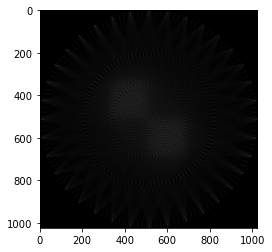

In [43]:
from matplotlib.pylab import imshow, imsave
from matplotlib import pyplot as plt

inverse = inverse_radon(sinogram, phi = phi_slider.value, size = 1024)

imshow(inverse, cmap = "gray")



In [44]:
from matplotlib.pylab import imshow, imsave
imsave("data/writes/inverse_blur.png", inverse, cmap = "gray")

In [45]:
from ipywidgets import Text, DatePicker, Button, Output
from IPython.display import display


class SaveState:
    def __init__(self):
        self.id = Text(description = "Patient's ID")
        self.name = Text(description = "Patient's Full Name")
        self.comments = Text(description = "Comments")
        self.date = DatePicker(description = "Study Date")
        self.filename = Text(description = "File name")
        self.save = Button(description = "Save")
        self.patient = None
        self.save.on_click(self.save_patient_data)
        display(self.id, self.name, self.comments, self.date, self.filename, self.save)

    def save_patient_data(self, _button):
        self.patient = {
            "id": self.id.value,
            "name": self.name.value,
            "date": self.date.value,
            "comments": self.comments.value
        }

        write_to_dicom(self.filename.value, inverse, self.patient)

save = SaveState()


Text(value='', description="Patient's ID")

Text(value='', description="Patient's Full Name")

Text(value='', description='Comments')

DatePicker(value=None, description='Study Date')

Text(value='', description='File name')

Button(description='Save', style=ButtonStyle())

In [46]:
# region TEST PURPOSE ONLY

print(save.patient)

# endregion TEST PURPOSE ONLY

{'id': 'ziom', 'name': 'ziomal', 'date': datetime.date(2022, 3, 31), 'comments': 'ona nie wie'}


In [47]:
from numpy import sqrt, mean

def rmse(image1, image2):
    return sqrt(mean((image1 - image2) ** 2))


In [49]:
img1 = cv.imread('data/phantom.png', cv.IMREAD_GRAYSCALE)
img2 = inverse
print(rmse(img1, img2))

62.51904710771414


In [ ]:
# test phi value impact
test_image = cv.imread('data/phantom.png', cv.IMREAD_GRAYSCALE)

phi_attr = []
phi_val = []
file = open('phi.txt', 'w+')
file.write('phi\trmse\n')

for phi_v in range(45, 271, 45):
    test_sinogram = radon(test_image, phi=phi_v,
                          step=2, count=18)
    reconstructed = inverse_radon(
        sinogram=test_sinogram, phi=phi_v, size=test_image[0].shape[0], use_filter = False)

    phi_attr.append(phi_v)
    phi_val.append(rmse(test_image, reconstructed))
    RMSE = rmse(test_image, reconstructed)
    file.write(str(phi_v) + '\t' + str(RMSE) + '\n')

file.close()

In [ ]:
# test scan number impact
test_image = cv.imread('data/phantom.png', cv.IMREAD_GRAYSCALE)
file = open('scans.txt', 'w+')
file.write('scans\trmse\n')
scan_attr = []
scan_val = []
for scan_number in range(90, 721, 90):
    test_sinogram = radon(image, phi=2,
                          step=360/scan_number, count=180)
    reconstructed = inverse_radon(
        sinogram=test_sinogram, phi=2, size=test_image[0].shape[0])

    scan_attr.append(scan_number)
    scan_val.append(rmse(test_image, reconstructed))
    file.write(str(scan_number) + '\t' + str(rmse(test_image, reconstructed)) + '\n')
file.close()

In [122]:
# test detectors number impact
test_image = cv.imread('data/phantom.png', cv.IMREAD_GRAYSCALE)
file = open('detectors.txt', 'w+')
file.write('detectors\trmse\n')
detectors_attr = []
detectors_val = []
for detectors_number in range(90, 721, 90):
    test_sinogram = radon(image, phi=180,
                          step=2, count=detectors_number)
    reconstructed = inverse_radon(
        sinogram=test_sinogram, phi=180, size=test_image[0].shape[0])

    detectors_attr.append(detectors_number)
    detectors_val.append(rmse(test_image, reconstructed))
    RMSE = rmse(test_image, reconstructed)
    file.write(str(detectors_number) + '\t' + str(RMSE) + '\n')

file.close()

Iteration count: 180
Iteration count: 180
Iteration count: 180
Iteration count: 180
Iteration count: 180
Iteration count: 180
Iteration count: 180
Iteration count: 180


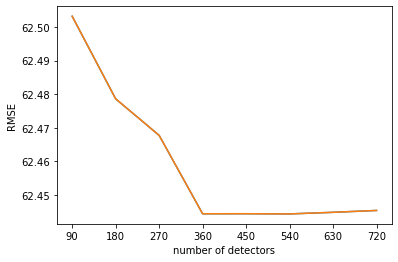

In [123]:
file = open('detectors.txt', 'r+')
data = [line for line in file]
x = [line.split('\t')[0] for line in data][1:]
y = [line.split('\t')[1][:10] for line in data][1:]
x = [int(i) for i in x]
y = [float(i) for i in y]
file.close()
plt.plot(x,y)
plt.plot(x, y)
plt.ylabel('RMSE')
plt.xlabel('number of detectors')
plt.xticks([x for x in range(90, 721, 90)]);

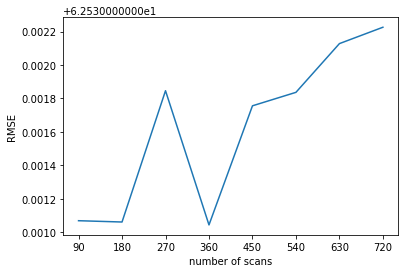

In [119]:
file = open('scans.txt', 'r+')
data = [line for line in file]
x = [line.split('\t')[0] for line in data][1:]
y = [line.split('\t')[1][:10] for line in data][1:]
x = [int(i) for i in x]
y = [float(i) for i in y]
file.close()
plt.plot(x, y)
plt.ylabel('RMSE')
plt.xlabel('number of scans')
plt.xticks([x for x in range(90, 721, 90)]);

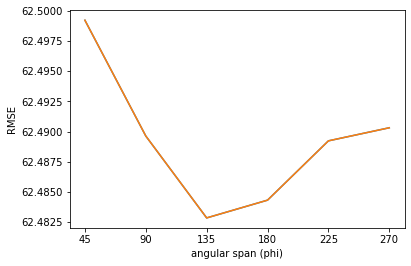

In [120]:
file = open('phi.txt', 'r+')
data = [line for line in file]
x = [line.split('\t')[0] for line in data][1:]
y = [line.split('\t')[1][:10] for line in data][1:]
x = [int(i) for i in x]
y = [float(i) for i in y]
file.close()
plt.plot(x,y)
plt.plot(x, y)
plt.ylabel('RMSE')
plt.xlabel('angular span (phi)')
plt.xticks([x for x in range(45, 271, 45)]);